In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/
%cd /content/lag-llama
!pip install -r requirements.txt --quiet

Cloning into 'lag-llama'...
remote: Enumerating objects: 328, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 328 (delta 114), reused 108 (delta 85), pack-reused 162 (from 1)
Receiving objects: 100% (328/328), 234.56 KiB | 2.61 MiB/s, done.
Resolving deltas: 100% (155/155), done.
/content/lag-llama
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 964.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 17.7 MB/s eta 0:00:0

In [2]:
pip install gluonts[torch]==0.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.9 MB/s eta 0:00:00
  Attempting uninstall: gluonts
    Found existing installation: gluonts 0.14.4
    Uninstalling gluonts-0.14.4:
      Successfully uninstalled gluonts-0.14.4


In [3]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 62.1MB/s]
Download complete. Moving file to /content/lag-llama/lag-llama.ckpt
/content/lag-llama/lag-llama.ckpt


In [4]:
from itertools import islice

import matplotlib.dates as mdates
import pandas as pd
import torch
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import Evaluator, make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [6]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,
        batch_size=1,
        num_parallel_samples=num_samples,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [7]:
pip install yfinance==0.2.37

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.41
    Uninstalling yfinance-0.2.41:
      Successfully uninstalled yfinance-0.2.41


In [34]:
def _get_lag_llama_dataset(dataset):
    # avoid mutations
    dataset = dataset.copy()

    # convert numerical columns to `float32`
    for col in dataset.columns:
        if dataset[col].dtype != "object" and not pd.api.types.is_string_dtype(
            dataset[col]
        ):
            dataset[col] = dataset[col].astype("float32")

    # create a `PandasDataset`
    backtest_dataset = PandasDataset(dict(dataset))
    return backtest_dataset




In [35]:
import yfinance as yf
# دانلود داده‌های سهام
ticker = 'AAPL'  # به عنوان مثال: Apple Inc.
stock_returns = yf.download(ticker, start="2023-01-01", end="2024-01-01")['Close'].resample('1D').ffill()
stock_returns

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2023-01-03,125.070000
2023-01-04,126.360001
2023-01-05,125.019997
2023-01-06,129.619995
2023-01-07,129.619995
...,...
2023-12-25,193.600006
2023-12-26,193.050003
2023-12-27,193.149994


In [52]:
import numpy as np
import pandas as pd
from tqdm import tqdm  # Import tqdm for progress bar
import torch

context_length = 64
prediction_length = 1  # پیش‌بینی برای روز بعد
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 4. حلقه برای پیش‌بینی کل داده‌ها با نوار پیشرفت
predicted_values = []
predicted_samples = []
results = []  # برای ذخیره نتایج نهایی

# استفاده از tqdm برای نمایش درصد پیشرفت
for i in tqdm(range(context_length, len(stock_returns) - prediction_length), desc="Processing"):
    # آماده‌سازی داده‌های ورودی
    input_data = stock_returns[i - context_length:i+1].to_frame()

    # آماده‌سازی dataset
    backtest_dataset = _get_lag_llama_dataset(input_data)

    # دریافت پیش‌بینی برای روز بعد
    forecasts, g = get_lag_llama_predictions(backtest_dataset, prediction_length, device, context_length, use_rope_scaling=False, num_samples=100)

    # استخراج اطلاعات مورد نیاز
    raw_forecast = np.mean(forecasts[0].samples)
    y_actual = stock_returns[input_data.index[-1]]
    train_start_date = input_data.index[0]
    train_end_date = input_data.index[-2]
    predict_date =  input_data.index[-1]
    batch_size = len(backtest_dataset)

    # ذخیره نتایج در یک دیکشنری
    result = {
        "input_index": i,
        "samples": np.mean(forecasts[0].samples),
        "train_start_date": train_start_date,
        "train_end_date": train_end_date,
        "predict_date": predict_date,
        "raw_forecast": raw_forecast,
        "y_actual": y_actual,
        "batch_size": batch_size,
        "context_len": context_length,
        "input_patch_len": len(input_data)
    }

    results.append(result)



# تبدیل نتایج به DataFrame
results_df = pd.DataFrame(results)




Processing: 100%|██████████| 296/296 [07:02<00:00,  1.43s/it]


In [53]:
# ذخیره DataFrame به صورت pickle
results_df.to_pickle('results_df_basic.pkl')

# نمایش پیغام موفقیت‌آمیز بودن عملیات
print("DataFrame successfully saved as 'results_df_basic.pkl'.")


DataFrame successfully saved as 'results_df_basic.pkl'.


In [44]:
import pandas as pd

# خواندن فایل pickle و ذخیره در متغیر results
results = pd.read_pickle('results_df_basic.pkl')
results.to_dict(orient='records')
# نمایش موفقیت‌آمیز بودن عملیات
print("DataFrame successfully loaded into 'results'.")


DataFrame successfully loaded into 'results'.


In [54]:
# تبدیل لیست نتایج به DataFrame
results_df = pd.DataFrame(results)

# نمایش DataFrame نهایی
results_df

,input_index,samples,train_start_date,train_end_date,predict_date,raw_forecast,y_actual,batch_size,context_len,input_patch_len
0,64,138.116638,2023-01-03,2023-03-07,2023-03-08,138.116638,152.869995,1,64,65
1,65,145.343216,2023-01-04,2023-03-08,2023-03-09,145.343216,150.589996,1,64,65
2,66,143.913879,2023-01-05,2023-03-09,2023-03-10,143.913879,148.500000,1,64,65
3,67,147.856842,2023-01-06,2023-03-10,2023-03-11,147.856842,148.500000,1,64,65
4,68,152.910278,2023-01-07,2023-03-11,2023-03-12,152.910278,148.500000,1,64,65
...,...,...,...,...,...,...,...,...,...,...
291,355,185.377655,2023-10-21,2023-12-23,2023-12-24,185.377655,193.600006,1,64,65
292,356,197.832428,2023-10-22,2023-12-24,2023-12-25,197.832428,193.600006,1,64,65
293,357,190.555222,2023-10-23,2023-12-25,2023-12-26,190.555222,193.050003,1,64,65
294,358,202.099976,2023-10-24,2023-12-26,2023-12-27,202.099976,193.149994,1,64,65


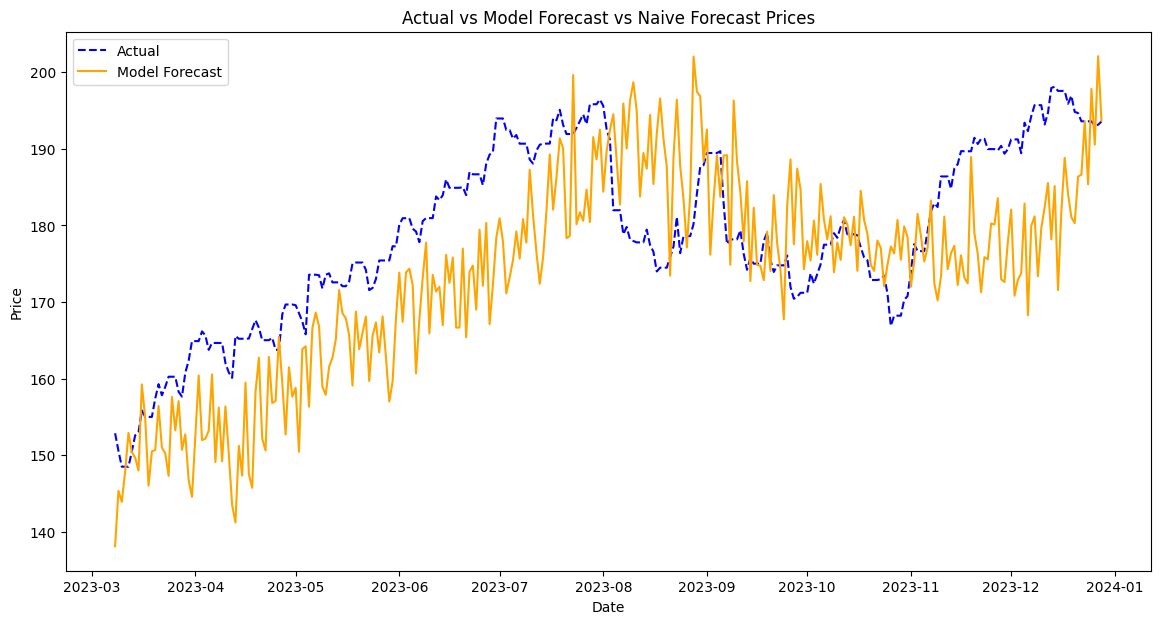

In [56]:
plt.figure(figsize=(14, 7))
plt.plot(results_df['predict_date'], results_df['y_actual'], label='Actual', color='blue', linestyle='--')
plt.plot(results_df['predict_date'], results_df['raw_forecast'], label='Model Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Model Forecast vs Naive Forecast Prices')
plt.legend()
plt.show()

In [62]:
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score

def calculate_mse(context_results_df):
    return mean_squared_error(context_results_df['y_actual'], context_results_df['raw_forecast'])

def calculate_accuracy(context_results_df):
    correct_predictions = 0
    total_predictions = 0
    for i in range(1, len(context_results_df)):
        actual_today = context_results_df['y_actual'].iloc[i]
        predicted_today = context_results_df['raw_forecast'].iloc[i]
        actual_yesterday = context_results_df['y_actual'].iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday
        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1

    return correct_predictions / total_predictions if total_predictions > 0 else 0

def calculate_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(1, len(context_results_df)):
        today_price = context_results_df['y_actual'].iloc[i]
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_actual_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['raw_forecast'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(2, len(context_results_df)):
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        yesterday_predicted_today_price = context_results_df['raw_forecast'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_predicted_today_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_predicted_today_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_results_for_context_len(context_len, results_by_context_len):
    # فیلتر کردن داده‌ها برای context_len مشخص شده
    context_results_df =results_by_context_len

    mse_value = calculate_mse(context_results_df)
    accuracy_value = calculate_accuracy(context_results_df)
    profit = calculate_profit(context_results_df)
    direction_accuracy = calculate_direction_accuracy(context_results_df)
    actual_direction_accuracy = calculate_actual_direction_accuracy(context_results_df)
    direction_profit = calculate_direction_profit(context_results_df)

    # ساخت دیکشنری از نتایج محاسبه شده
    result = {
        'context_len': context_len,
        'mse': mse_value,
        'accuracy': accuracy_value,
        'direction_accuracy': direction_accuracy,
        'actual_direction_accuracy': actual_direction_accuracy,
        'direction_profit': direction_profit,
        'profit': profit
    }

    return pd.DataFrame([result])

# فراخوانی تابع برای یک context_len خاص
context_len = 64  # برای مثال
final_result_df = calculate_results_for_context_len(context_len, results_df)
print(final_result_df)


   context_len         mse  accuracy  direction_accuracy  \
0           64  125.532561  0.349153            0.461017   

   actual_direction_accuracy  direction_profit    profit  
0                   0.583051         -1.163488  3.099886  


In [58]:
initial_investment = 100
initial_price = results_df['y_actual'].iloc[0]
final_price = results_df['y_actual'].iloc[-1]


# Calculate the number of shares bought initially
shares_bought = initial_investment / initial_price

# Calculate the final value of the investment
final_investment_value = shares_bought * final_price

# Calculate the total profit
buy_and_hold_profit = final_investment_value - initial_investment
buy_and_hold_profit

26.630475576753682